In [2]:
import os
import shutil
import re
import subprocess
import dicom2nifti
import SimpleITK as sitk
import numpy as np
import nibabel as nib
import ants
import time
#import gui # git clone https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks.git
import matplotlib.pyplot as plt
#import JupyterNotebooksLib as slicernb
#import slicer

#==========================================================================================================================================================
# CODE DESCRIPTION:

# 1) FILE PATHS ARE SUPPLIED FOR THE PARENT DIRECTORIES OF THE:
	# 1a) FRC FILES [/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done]
	# 1b) TLC FILES [\\lc-rs-store25.hpc.uiowa.edu\teamwork\public_resources\Scan_Exchange\for_Junfeng\SPIR--ATS-VessDys-TLCs\1-UseThis-Unzipped-APKs]
	# 1c) COMPLETED CASE DIRECTORIES [/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done]
# 2) CASE NUMBERS ('Case-##') & CASE PATHS ARE STORED IN SEPARATE LISTS DERIVED FROM THE COMPLETED CASE DIRECTORIES
# 3) CASES ARE LOOPED THROUGH FOR REGISTRATION PROCESSING:
	# 3) 3a) A SUBDIRECTORY IS CREATED IN 

#==========================================================================================================================================================

####################################################################################################################################

#*******************************
# TESTED FOR BASIC FUNCTIONALITY
#*******************************

# FUNCTION TO GET/STORE ALL OF THE CASE NUMBERS AND DIRECTORY PATHS USED WITH OTHER FUNCTIONS AND THE FINAL PRINT STATEMENT FOR EACH COMPLETED REGISTRATION

def get_case_nums(casePath):
    workDir = casePath
    caseNums = []
    caseDirs = []
    for item in os.listdir(workDir):
        if(item.startswith("Case-") or item.startswith("case-") ):
            #newCaseDir = casePath + "\\" + item
            newCaseDir = os.path.join(workDir, item)
            #caseDirs.append(os.path.join(casePath, item)) ##

            #caseDirs.append(newCaseDir)
            #repr(caseDirs.append(casePath + "\\" + item))
            caseDirs.append(newCaseDir)
            # CHECKS FOR 'Case-' + NUMBERS MATCH IN DIRECTORY NAME -> CASE INSENSITIVE
            match = re.match(r'(?i)Case-(\d+)', item)
            if match:
                caseN = "Case-" + match.group(1)
                caseNums.append(caseN)
        # if os.path.isdir(os.path.join(workDir, item) and item.startswith("Case-") or item.startswith("case-")):
        #     print("match")
        #     match = re.match(r'Case-(\d+)-(\d+)', item)
        #     print(match)
        #     if match:
        #         caseN = "Case-" + match.group(1) + match.group(2)
        #         print("Match found: " + caseN)
        #         caseNums.append(caseN)
    print("Case numbers found:")
    print(caseNums)
    print("Case directories found:")
    print(caseDirs)
    return caseNums, caseDirs

####################################################################################################################################

# CREATES OUTPUT DIRECTORY WITHIN SUBDIRECTORY NAMED AFTER CASE-##
# 'folder_path' STORES PATH TO OUTPUT DIRECTORY WHERE FILES ARE COPIED TO
# SUBDIRECTORY WILL BE MADE HERE TO STORE THE 'MOVING' FILE AFTER REGISTRATION

def create_case_folder(caseN, caseD):
    folder_name = caseN + "_registered"
    folder_path = os.path.join(caseD, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    print("Case folder created...")
    return folder_path

####################################################################################################################################

#Not Functional with certain cases: Function finds and copies the FRC file to U-AllysonRegistration and Case ID. There is a lot of variability for what type of file is available for FRC for each case so pick the best optioon and manually copy to correct folder. 

# COPIES FRC FILE FROM SUPPLIED SOURCE DIRECTORY 'frcPath' TO 'folder_path' DIRECTORY, WHERE REGISTRATION WILL BE DONE

def load_FRC_find_CaseID(case_number, folder_path, frcPath):
    found_file = None
    case_id = None
    destination_folder = folder_path
    #source_folder = "z:/D-Images/SPIROMICS-SubStudy/2-Results-CheckedDoneTemp/1-Done"
    source_folder = frcPath
	
    for root, dirs, files in os.walk(source_folder):
        for dir_name in dirs:
            #if dir_name.startswith(f"Case-{case_number}"):
            if dir_name.startswith(case_number):
                case_folder = os.path.join(root, dir_name)
                additional_images_folder = os.path.join(case_folder, "Additional Images")

                if os.path.exists(additional_images_folder):
                    for root2, dirs2, files2 in os.walk(additional_images_folder):
                        for file in files2:
                            if "0.5" in file and "150KV" in file:
                                found_file = os.path.join(root2, file)
                                destination_path = os.path.join(destination_folder, os.path.basename(found_file))
                                shutil.copy(found_file, destination_path)

                                # Extract the Case ID from the file name
                                case_id_match = re.search(r'(?<=SPI-)([^_]+)-PBV_SPIROMICS', found_file)
                                case_id = case_id_match.group(1)
                                print(f"Case ID: {case_id}")
                                break
    print("FRC case id identified:")
    print(case_id)
    return case_id

####################################################################################################################################

#Not Working: Function finds the TLC folder in teamwork and copies to Case Folder. This had some sort of access/permission needed error so again this needs to be maunally copied over to the correct case folder. 

def load_TLC_folder(case_id, folder_path):
    found_file = None
    #source_folder = r"\\lc-rs-store25.hpc.uiowa.edu\teamwork\public_resources\Scan_Exchange\for_Junfeng\SPIR--ATS-VessDys-TLCs\1-UseThis-Unzipped-APKs" # EDIT THIS
    source_folder = folder_path
    destination_folder = folder_path

    for root, dirs, files in os.walk(source_folder):
        for dir in dirs:
            if case_id in dir:
                found_file = os.path.join(root, dir)

                destination_apk_path = os.path.join(destination_folder, found_file)
                shutil.copy(found_file, destination_apk_path)
    print("TLC folder copied to case file successfully")

####################################################################################################################################

# LOADS TLC DICOM SERIES AND CONVERTS IT TO A '*.nii.gz' FILE IN THE 'folder_path' DIRECTORY

def load_TLC_DICOM(case_id, folder_path, tlcPath):
    #source_folder = folder_path
    source_folder = tlcPath

    subfolders = [f for f in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, f))]
    target_subfolder = None

    for subfolder in subfolders:
        if "TLC" in subfolder and str(case_id) in subfolder:
            target_subfolder = subfolder
            break

    if target_subfolder is None:
        print(f"Error: Subfolder with case id and 'TLC' not found.")
        return None

    target_subfolder_path = os.path.join(source_folder, target_subfolder)

    dicom_folder_path = None
    for root, dirs, files in os.walk(target_subfolder_path):
        if 'dicom' in dirs:
            dicom_folder_path = os.path.join(root, 'dicom')
            print(dicom_folder_path)
            break

    #nifti_output_path = source_folder
    nifti_output_path = folder_path
	
	# CONVERT TLC DICOMS TO .nii.gz FILES
    dicom2nifti.convert_directory(dicom_folder_path, nifti_output_path, compression=True, reorient=True)
    print('TLC DICOM loaded successfully')

####################################################################################################################################

# RENAMES THE FRC AND TLC *.nii.gz FILES IN THE 'folder_path' DIRECTORY

def rename_files(case_id, folder_path):
    source_folder = folder_path

    for filename in os.listdir(source_folder):
        # Check if the file name contains a certain case id
        if "SN150KV" in filename and case_id in filename and filename.endswith(".nii.gz"):
            if not os.path.exists(source_folder + "\\FRC-DICOM.nii.gz"):
                new_filename = "FRC-DICOM.nii.gz"
                old_file_path = os.path.join(source_folder, filename)
                new_file_path = os.path.join(source_folder, new_filename)
                # Rename the file
                os.rename(old_file_path, new_file_path)
        # Check if the file name contains "inspiration" and ends with .nii.gz
        elif "inspiration" in filename and filename.endswith(".nii.gz"):
            if not os.path.exists(source_folder + "\\TLC-DICOM.nii.gz"):
                new_filename = "TLC-DICOM.nii.gz"
                old_file_path = os.path.join(source_folder, filename)
                new_file_path = os.path.join(source_folder, new_filename)
                # Rename the file
                os.rename(old_file_path, new_file_path)
        else:
            # Skip files that don't match the specified conditions
            continue
        if(os.path.exists(source_folder + "\\FRC-DICOM.nii.gz") and os.path.exists(source_folder + "\\TLC-DICOM.nii.gz")):
            print("No file renaming required")

    print('Files renamed successfully')

####################################################################################################################################

#export ITK_NIFTI_SFORM_PERMISSIVE=1

# RUNS AN ANTsPy REGISTRATION ON THE FRC & TLC FILES IN THE 'folder_path' DIRECTORY
# THE MOVING/WARPED FILE WILL BE EXPORTED TO A SUBDIR OF 'folder_path' -> 'outFolderPath'

def run_registration(folder_path):

	#======================================================================================================
	# NOTE: ANTsImage TYPES (EX below: movingImg) ACT BASICALLY AS A NUMPY ARRAY
	#EX: CLONING CONVERT TO NUMPY, NEW IMG WITH SAME PROPERTIES BUT NEW DATA, FILE SAVE,STATS, ETC
	#======================================================================================================

	# https://antspy.readthedocs.io/en/latest/registration.html#module-ants
    # https://antspy.readthedocs.io/en/latest/_modules/ants/registration/interface.html#registration

    source_folder = folder_path

	# CREATE OUTPUT DIRECTORY FOR REGISTRATION RESULTS
    outFolderPath = os.path.join(source_folder, "ANTsPy_Registration_Outputs")
    os.makedirs(outFolderPath, exist_ok=True)

    outFixedFileName = "WARPED_DATASET_fixedFile.nii.gz"
    outMovingFileName2 = "WARPED_DATASET_warped_warpedmovout1_case22_float.nii.gz"
    outMovingFileName3 = "WARPED_DATASET_warped_warpedmovout2_float.nii.gz"

    # SETS THE OUTPUT DIRECTORY FOR THE REGISTERED IMAGE
    outputDir = os.path.join(source_folder, outFolderPath)
    outputFilePath = os.path.join(outputDir, outFixedFileName)
    outputFilePath2 = os.path.join(outputDir, outMovingFileName2)
    outputFilePath3 = os.path.join(outputDir, outMovingFileName3)

	# SETS FILEPATHS
	# NOTE: MAY NEED TO AUTOMATE METHOD TO DECLARE FILE NAME + EXTENSION, OR USE REGEX TO GET THIS
    # NOTE 2: FRC = fixed, TLC = moving
    fixedImgPath = os.path.join(source_folder, "FRC-DICOM.nii.gz")
    movingImgPath = os.path.join(source_folder, "TLC-DICOM.nii.gz")
	
    print("Reading in datasets...")
    print("Fixed dataset path: " + fixedImgPath)
    print("Moving dataset path: " + movingImgPath)
	
	#------------------------------------------------------------------------------------------------------
	
# TRY/EXCEPT IS USED TO CATCH FILES WITH HEADER ISSUES
# FILES WITH HEADER ISSUES WILL HAVE THEIR NAMES LOGGED TO A TEXT FILE FOR MANUAL PROCESSING?
    # ALTERNATIVE: GET SlicerANTs MODULE WORKING FROM PYTHON CODE
    
    #try
    
    print("Entering 'try'")
    # READ IN FILES FROM FILEPATH VIA 'ANTS' FUNCTION
    # Supported types are 'float', 'double', 'unsigned int', 'unsigned char'
    fixedImg = ants.image_read(fixedImgPath, pixeltype="float", reorient=False)
    movingImg = ants.image_read(movingImgPath, pixeltype="float", reorient=False)

    #------------------------------------------------------------------------------------------------------

    # PRINTS PLOT OF CENTER AXIAL IMAGE BEFORE REGISTRATION - USED FOR COMPARISON (OPTIONAL)
    #fixedImg.plot(overlay=moving, title ='Before Registration')

    # REGISTERS A PAIR OF IMAGES THROUGH FULL OR SIMPLIFIED ANTs REG METHOD
    # 'Symmetric normalization' (SyN): Affine + deformable transformation, with mutual information as optimization metric

    print("Registering moving dataset using 'QuickRigid'...")
    
    transf = ants.registration(fixed=fixedImg, moving=movingImg, type_of_transform='QuickRigid') # BETTER REGISTRATION METHOD = "SyN"

    #print(transf)
    print("Moving dataset registered...")
    print("Warping moving image...")

    # 
    warped_moving = transf['warpedmovout']

    # PRINTS PLOT OF IMAGES AFTER REGISTRATION
    #fixed.plot(overlay=warped_moving,vtitle='After Registration')
    
    print("Applying transforms to moving image...")

    # USE THE TRANSFORMS OUTPUT FROM REGISTRATION AND APPLY THEM DIRECTLY TO THE IMAGE
    # ***REVIEW THIS***
    warpedImage1 = ants.apply_transforms(fixedImg, movingImg, transformlist=transf['fwdtransforms'])
    ants.image_write(warpedImage1, outputFilePath2, ri=False)# USE THIS 
    
    print("Path to warped file:")
    print(outputFilePath2)

    print("Saving registered moving dataset to file...")
    
    
    # Example images (you need to load your medical images here)
    #fixedImg = np.random.rand(100, 100)
    #warpedImage1 = np.random.rand(100, 100)

	# Create a figure and axis
    fig, ax = plt.subplots()

	# Combine the images into a checkerboard pattern
    combined_image = np.zeros((fixedImg.shape[0]*2, warpedImage1.shape[1]*2))
    combined_image[::2, ::2] = fixedImg
    combined_image[1::2, 1::2] = warpedImage1

	# Display the combined image
    ax.imshow(combined_image, cmap='gray')

	# Remove axis ticks
    ax.axis('off')

	# Show the plot
    plt.show()

    #------------------------------------------------------------------------------------------------------
    # PRINT PLOT OF 10 CHECKERBOARD IMAGES (FRC/TLC) EVENLY SPACED THROUGH THE DATASETS TO SHOW ACCURACY OF REGISTRATION
    # WIP
    # http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/05_Results_Visualization.html
    #gui.MultiImageDisplay(image_list = [sitk.CheckerBoard(img1, img2, [4,4,4]), sitk.CheckerBoard(img1_255, img2_255, (10,10,4))],
                    #title_list = ['original intensities', 'rescaled intensities'],
                    #figure_size=(9,3));
    #------------------------------------------------------------------------------------------------------

    #except

    #match = re.match(r'(?i)Case-(\d+)', fixedImgPath)
    #print("-> Error encountered with " + match + ". Skipping...")

    # TRY TO GET slicerANTs WORKING FOR FILES WITH HEADER ISSUES?
	
    return outputFilePath2
	



Case numbers found:
['Case-24']
Case directories found:
['C:\\Users\\Adam\\Downloads\\registration_code\\FILES\\case-24']
Cases found at C:\Users\Adam\Downloads\registration_code\FILES

['Case-24']
Case folder created...
Case ID: JH110704
FRC case id identified:
JH110704
C:\Users\Adam\Downloads\registration_code\FILES\tlc\H-14519_JH110704_SPI-JH110704-V2_TLC_0.75_B35f_27153060\H-14519_JH110704_SPI-JH110704-V2_TLC_0.75_B35f_27153060\dicom
TLC DICOM loaded successfully
No file renaming required
No file renaming required
Files renamed successfully
Reading in datasets...
Fixed dataset path: C:\Users\Adam\Downloads\registration_code\FILES\case-24\Case-24_registered\FRC-DICOM.nii.gz
Moving dataset path: C:\Users\Adam\Downloads\registration_code\FILES\case-24\Case-24_registered\TLC-DICOM.nii.gz
Entering 'try'
Registering moving dataset using 'QuickRigid'...
Moving dataset registered...
Warping moving image...
Applying transforms to moving image...
Path to warped file:
C:\Users\Adam\Downloads\

ValueError: setting an array element with a sequence.

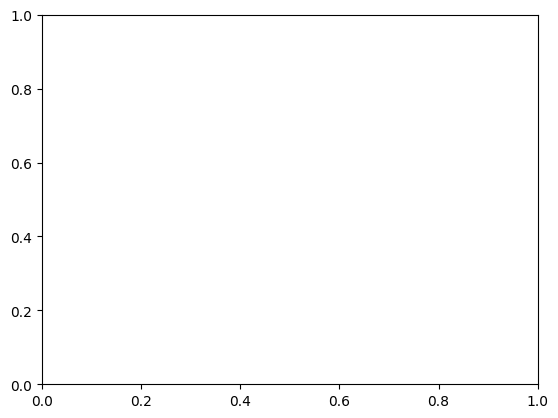

In [3]:
# FUNCTION CALLS
#===============

#folder_path - r"J:\\SOHEIL_PROJECT\\Code\\ANTsPy_registration_testing\\slicerANTs\\case-30"

caseNums = []

casePath = r"C:\Users\Adam\Downloads\registration_code\FILES"
frcPath = r"C:\Users\Adam\Downloads\registration_code\FILES\frc"
tlcPath = r"C:\Users\Adam\Downloads\registration_code\FILES\tlc"

# GET CASE NUMBERS & CASE DIRECTORY PATHS
caseNums, caseDirs = get_case_nums(casePath)

print("Cases found at " + casePath + "\n")
print(caseNums)

increment = 1

outputFilePath2 = ''

# CREATE 'FOR' LOOP TO ITERATE THROUGH THE LIST OF CASES TO GET THEIR MATCHING FRC/TLC FILES AND REGISTER EACH HERE
for caseN, caseD in zip(caseNums, caseDirs):
	# NOTE: REVIEW THESE FUNCTIONS
	folder_path = create_case_folder(caseN, caseD)
	case_id = load_FRC_find_CaseID(caseN, folder_path, frcPath)
	load_TLC_DICOM(case_id, folder_path, tlcPath)
	rename_files(case_id, folder_path)
	
	#---------------------------------------------
	# REGISTRATION FUNCTION & REGISTRATION TIME ELAPSE

	startTime = time.time()
	# PERFORM TLC REGISTRATION TO FRC FILE, RETURN PATH TO WARPED FILE
	outputFilePath2 = run_registration(folder_path)
	print(outputFilePath2)
	endTime = time.time()

	# TIME IN SECONDS
	elapsedTimeS = endTime - startTime
	# TIME IN MINUTES
	elapsedTimeM = elapsedTimeS/60

	#****************************************************************************************************************
	# WIP

	# INCLUDE PRINT STATEMENT THAT INCLUDES CASE-##, REGISTRATION TIME, LOCATIONS OF THE FRC/TLC/WARPED IMAGE
	# NOTE: NEET TO STORE PATHS TO CURRENT TL/FRC/WARPED FILES
	print(caseN + ": \nTLC [" + tlcPath + "] registered to \nFRC [" + frcPath + "] \n-> warped file created [" + outputFilePath2 + "] \nin " + str(elapsedTimeS) + " seconds (" + str(elapsedTimeM) + " minutes)\n")

	#****************************************************************************************************************

	#---------------------------------------------
	

In [94]:

print(folder_path)
run_registration(folder_path)

C:\Users\Adam\Downloads\registration_code\FILES\case-24\Case-24_registered
Reading in datasets...
Fixed dataset path: C:\Users\Adam\Downloads\registration_code\FILES\case-24\Case-24_registered\FRC-DICOM.nii.gz
Moving dataset path: C:\Users\Adam\Downloads\registration_code\FILES\case-24\Case-24_registered\TLC-DICOM.nii.gz
Entering 'try'
Registering moving dataset using 'Syn'...


MemoryError: bad allocation

In [116]:
increment = 1

print(type(caseN))
print(tlcPath)
print(frcPath)
print(outputFilePath2)
print(type(elapsedTimeS))
print(type(elapsedTimeM))
print(caseN + ": \nTLC [" + tlcPath + "] registered to \nFRC [" + frcPath + "] \n-> warped file created [" + outputFilePath2 + "] \nin " + str(elapsedTimeS) + " seconds (" + str(elapsedTimeM) + " minutes)\n")


<class 'str'>
C:\Users\Adam\Downloads\registration_code\FILES\tlc
C:\Users\Adam\Downloads\registration_code\FILES\frc
C:\Users\Adam\Downloads\registration_code\FILES\case-24\Case-24_registered\ANTsPy_Registration_Outputs\WARPED_DATASET_warped_warpedmovout1_case22_float.nii.gz
<class 'float'>
<class 'float'>
Case-24: 
TLC [C:\Users\Adam\Downloads\registration_code\FILES\tlc] registered to 
FRC [C:\Users\Adam\Downloads\registration_code\FILES\frc] 
-> warped file created [C:\Users\Adam\Downloads\registration_code\FILES\case-24\Case-24_registered\ANTsPy_Registration_Outputs\WARPED_DATASET_warped_warpedmovout1_case22_float.nii.gz] 
in 535.5757026672363 seconds (8.926261711120606 minutes)

